## Import Modules

In [30]:
import json
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "5" 
os.environ['http_proxy'] = '10.106.130.4:3128'
os.environ['https_proxy'] = '10.106.130.4:3128'
import time
import socket
from pathlib import Path
import cv2
import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
from torch.distributions import MultivariateNormal
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from pixel_generator.mage import models_mage
from PIL import Image
from imagenet_clstolabel import IMGNET_CLASS2LABEL
from IPython.display import display
import lpips

In [31]:
def viz_torchimage(image):
    image = torch.clamp(image, 0, 1)
    image_np = image.detach().cpu().numpy().transpose([1, 2, 0])
    image_np = Image.fromarray(np.uint8(image_np*255))
    display(image_np)

<-- ----------------------------------------------------------------------- -->

# Large version inference

## 1. Load pre-trained encoder, RDM and MAGE

In [32]:
# Initialize RCG-L
class_cond = True
if class_cond:
    rdm_ckpt_path = 'final_ckpts/rdm-mocov3vitl-clscond.pth'
    rdm_cfg = 'config/rdm/mocov3vitl_simplemlp_l12_w1536_classcond.yaml'
else:
    rdm_ckpt_path = 'final_ckpts/rdm-mocov3vitl.pth'
    rdm_cfg = 'config/rdm/mocov3vitl_simplemlp_l12_w1536.yaml'
    
mg_kwargs = {
    'use_ms_grad': True,
    'norm_for_mg': 2.0,
    't_mid': -1.0,  # -1.0 for no early stop
    'mg_scale': 0.15,
    'p_ratio': 0.5,
    'num_mc_samples': 1,
    'mg_scale_type': 'var',
    'use_normed_grad': True,
    'use_lpips': False,
    'inter_rate': 1,
}
if mg_kwargs['use_lpips']:
    loss_lpips = lpips.LPIPS(net='alex').cuda()
    mg_kwargs['loss_lpips'] = loss_lpips
model = models_mage.mage_vit_large_patch16(mask_ratio_mu=0.75, mask_ratio_std=0.25,
                                           mask_ratio_min=0.5, mask_ratio_max=1.0,
                                           vqgan_ckpt_path='vqgan-ckpts/vqgan_jax_strongaug.ckpt',
                                           use_rep=True, rep_dim=256, rep_drop_prob=0.1,
                                           use_class_label=False,
                                           pretrained_enc_arch='mocov3_vit_large',
                                           pretrained_enc_path='pretrained_enc_ckpts/mocov3/vitl.pth.tar',
                                           pretrained_enc_proj_dim=256,
                                           pretrained_enc_withproj=True,
                                           pretrained_rdm_ckpt=rdm_ckpt_path,
                                           pretrained_rdm_cfg=rdm_cfg,
                                           mg_kwargs=mg_kwargs)
checkpoint = torch.load(os.path.join('final_ckpts/mage-l.pth'), map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=True)
model.cuda()
_ = model.eval()

Use representation as condition!
Loading model from final_ckpts/rdm-mocov3vitl-clscond.pth
RDM: Running in x0-prediction mode
DiffusionWrapper has 72.18 M params.
Keeping EMAs of 156.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Strict load
Restored from vqgan-ckpts/vqgan_jax_strongaug.ckpt


### 2. Image Generation

1: goldfish, Carassius auratus


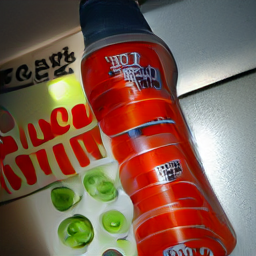

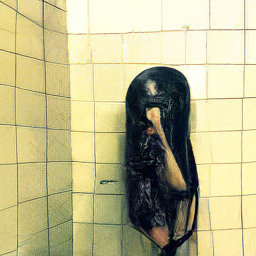

323: monarch, monarch butterfly, milkweed butterfly, Danaus plexippus


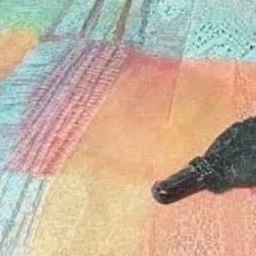

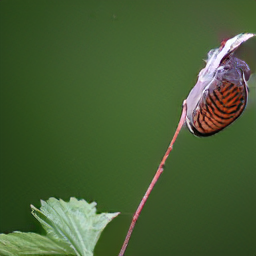

985: daisy


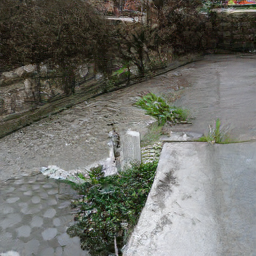

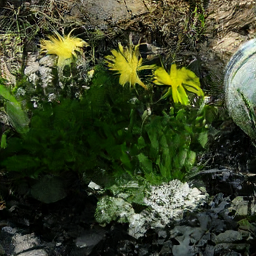

In [35]:
# torch.manual_seed(7)
# np.random.seed(7)

n_image_to_gen = 2
rdm_steps = 250
rdm_eta = 1.0
mage_temp = 11.0
mage_steps = 20
cfg = 6.0  # 6.0

if class_cond:
    for class_label in [1, 323, 985]:
        print("{}: {}".format(class_label, IMGNET_CLASS2LABEL[class_label]))
        class_label = class_label * torch.ones(1).cuda().long()
        for i in range(n_image_to_gen):
            gen_images, _ = model.gen_image(1, num_iter=mage_steps, choice_temperature=mage_temp, sampled_rep=None, rdm_steps=rdm_steps, eta=rdm_eta, cfg=cfg, class_label=class_label)
            viz_torchimage(gen_images[0])

else:
    for i in range(n_image_to_gen):
        gen_images, _ = model.gen_image(1, num_iter=mage_steps, choice_temperature=mage_temp, sampled_rep=None, rdm_steps=rdm_steps, eta=rdm_eta, cfg=cfg, class_label=None)
        viz_torchimage(gen_images[0])